In [1]:
# Cell 1: Import Libraries
import os
import pandas as pd
import numpy as np
import boto3
from botocore.client import Config
from botocore.exceptions import ClientError
from io import BytesIO
from datetime import datetime

# IMPORTANT: Ensure pyarrow is installed for reading Parquet files
# If not, run: !pip install pyarrow
import pyarrow.parquet as pq

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Global Configuration ---
TARGET_SYMBOL = "MSFT" # Change this symbol to analyze different stocks (e.g., "AAPL", "GOOGL", "AMZN")
# --- End Global Configuration ---

In [2]:
# Cell 2: Load MinIO Details from config.py and Environment Variables
import os
from config import MINIO_CONFIG # Import MINIO_CONFIG from your config.py

# Load MinIO details, preferring environment variables if set,
# otherwise falling back to values from config.py
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT", f"http://{MINIO_CONFIG['endpoint']}")
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY", MINIO_CONFIG['access_key'])
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY", MINIO_CONFIG['secret_key'])

# Basic validation
if not MINIO_ACCESS_KEY or not MINIO_SECRET_KEY:
    print("Error: MinIO credentials not loaded. Please ensure they are set in environment variables or config.py.")
    # Depending on your preference, you might want to raise an exception here
    # raise ValueError("MinIO credentials missing.")
else:
    print("MinIO credentials loaded successfully.")
    print(f"Using MinIO Endpoint: {MINIO_ENDPOINT}") # Added for verification


MinIO credentials loaded successfully.
Using MinIO Endpoint: http://159.223.139.171:9000


In [3]:
# Cell 3: Initialize MinIO S3 client
s3_client = None
try:
    s3_client = boto3.client(
        's3',
        endpoint_url=MINIO_ENDPOINT,
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        config=Config(signature_version='s3v4'),
        region_name='us-east-1' # Placeholder region
    )
    s3_client.list_buckets() # Test connection
    print(f"MinIO S3 client initialized and connected to endpoint: {MINIO_ENDPOINT}")
except Exception as e:
    print(f"Error initializing or connecting to MinIO S3 client: {e}")
    print("Please ensure MinIO Docker container is running and accessible.")
    s3_client = None # Set to None if initialization fails


MinIO S3 client initialized and connected to endpoint: http://159.223.139.171:9000


In [4]:
# Cell 4: Helper Function to Read Processed Parquet Data for a Symbol
def load_processed_data_from_minio(bucket_name, data_type_prefix, symbol):
    if not s3_client:
        print("MinIO client not available, cannot load data.")
        return pd.DataFrame()

    all_dataframes = []
    # Construct the prefix to look for processed data for a specific symbol
    # Example: processed-financial-data/finnhub_quotes/AAPL/
    # Or: processed-financial-data/twelvedata_historical/AAPL/
    prefix = f"{data_type_prefix}/{symbol}/"

    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

        for page in pages:
            if "Contents" in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        try:
                            response = s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])
                            parquet_data = response['Body'].read()
                            df = pd.read_parquet(BytesIO(parquet_data))
                            all_dataframes.append(df)
                        except Exception as e:
                            print(f"Error reading {obj['Key']} from MinIO: {e}")
        if all_dataframes:
            # Concatenate all dataframes and sort by the relevant timestamp/datetime column
            combined_df = pd.concat(all_dataframes, ignore_index=True)

            # Convert to datetime, force UTC, then localize to naive (no timezone info)
            if 'datetime' in combined_df.columns:
                combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], utc=True, errors='coerce')
                combined_df['datetime'] = combined_df['datetime'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='datetime').drop_duplicates(subset=['datetime']).set_index('datetime')
            elif 'timestamp' in combined_df.columns:
                combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], utc=True, errors='coerce')
                combined_df['timestamp'] = combined_df['timestamp'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='timestamp').drop_duplicates(subset=['timestamp']).set_index('timestamp')

            return combined_df
        else:
            print(f"No processed data found for {symbol} under {data_type_prefix}.")
            return pd.DataFrame()
    except ClientError as e:
        print(f"MinIO Client Error when listing objects in s3://{bucket_name}/{prefix}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"General error loading data for {symbol} from MinIO: {e}")
        return pd.DataFrame()

In [5]:
# Cell 5: Load and Inspect Finnhub Quotes for AAPL
processed_finnhub_quotes_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="finnhub_quotes",
    symbol=TARGET_SYMBOL # Use the global configuration variable
)

print(f"\nProcessed Finnhub Quotes for {TARGET_SYMBOL} (first 5 rows):")
print(processed_finnhub_quotes_df.head())
print(f"\nProcessed Finnhub Quotes Info for {TARGET_SYMBOL}:")
processed_finnhub_quotes_df.info()


Processed Finnhub Quotes for MSFT (first 5 rows):
             fetch_timestamp   close    high     low    open  prev_close  \
0 2025-07-05 18:15:29.107872  498.84  500.13  493.44  493.81      491.09   
1 2025-07-05 18:30:10.130162  498.84  500.13  493.44  493.81      491.09   
2 2025-07-05 18:54:23.962914  498.84  500.13  493.44  493.81      491.09   

   spread symbol  
0    6.69   MSFT  
1    6.69   MSFT  
2    6.69   MSFT  

Processed Finnhub Quotes Info for MSFT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fetch_timestamp  3 non-null      datetime64[us]
 1   close            3 non-null      float64       
 2   high             3 non-null      float64       
 3   low              3 non-null      float64       
 4   open             3 non-null      float64       
 5   prev_close       3 non-null      float64       
 6 

In [6]:
# Cell 6: Load and Inspect Twelve Data Historical for AAPL
processed_twelvedata_historical_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="twelvedata_historical",
    symbol=TARGET_SYMBOL # Use the global configuration variable
)

print(f"\nProcessed Twelve Data Historical for {TARGET_SYMBOL} (first 5 rows):")
print(processed_twelvedata_historical_df.head())
print(f"\nProcessed Twelve Data Historical Info for {TARGET_SYMBOL}:")
processed_twelvedata_historical_df.info()



Processed Twelve Data Historical for MSFT (first 5 rows):
                  open        high        low       close    volume  \
datetime                                                              
2022-08-05  279.149990  283.649990  278.67999  282.910000  16774600   
2022-08-08  284.049988  285.920010  279.32001  280.320010  18739200   
2022-08-09  279.640010  283.079987  277.60999  282.299990  23405200   
2022-08-10  288.170010  289.810000  286.94000  289.160000  24687800   
2022-08-11  290.850010  291.209990  286.51001  287.019989  20065900   

            daily_return symbol  
datetime                         
2022-08-05           NaN   MSFT  
2022-08-08     -0.009155   MSFT  
2022-08-09      0.007063   MSFT  
2022-08-10      0.024300   MSFT  
2022-08-11     -0.007401   MSFT  

Processed Twelve Data Historical Info for MSFT:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-08-05 to 2025-07-03
Data columns (total 7 columns):
 #   Column        Non-Null Count

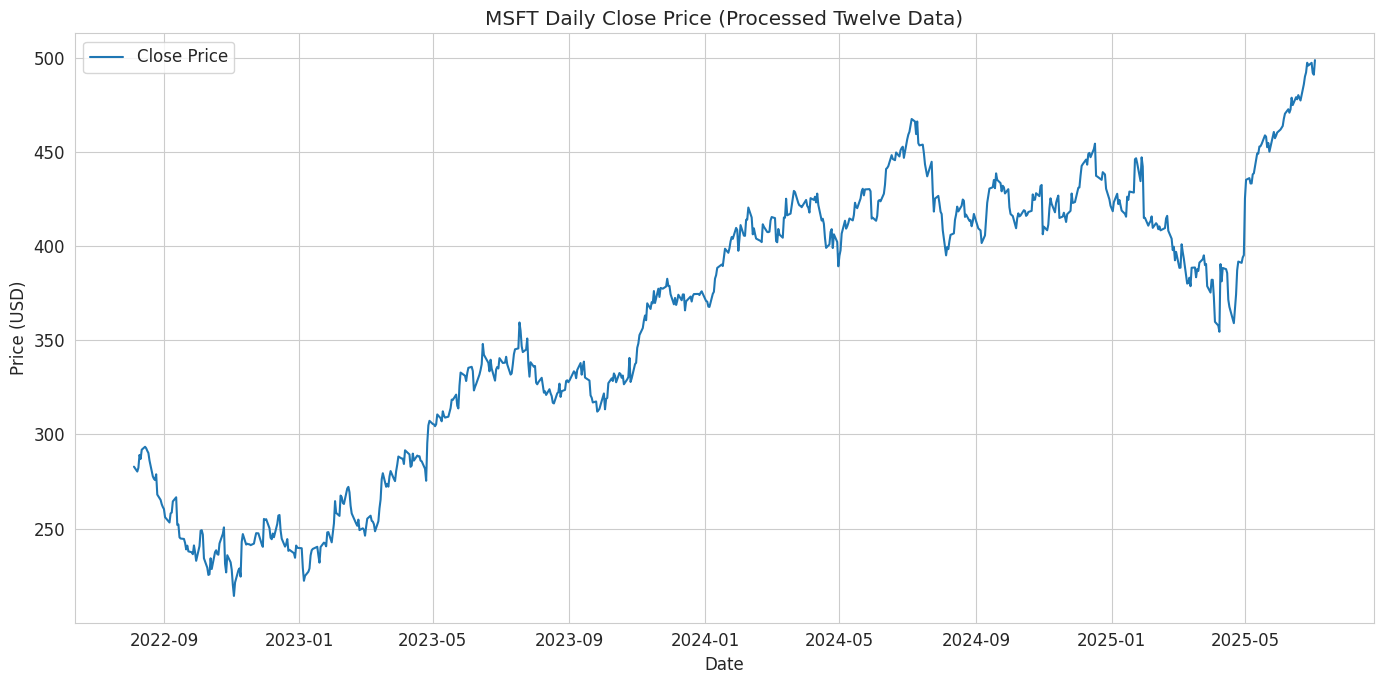

In [7]:
# Cell 7: Basic Visualization - Twelve Data Historical Close Price
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price')
    plt.title(f'{TARGET_SYMBOL} Daily Close Price (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data historical close price for AAPL.")

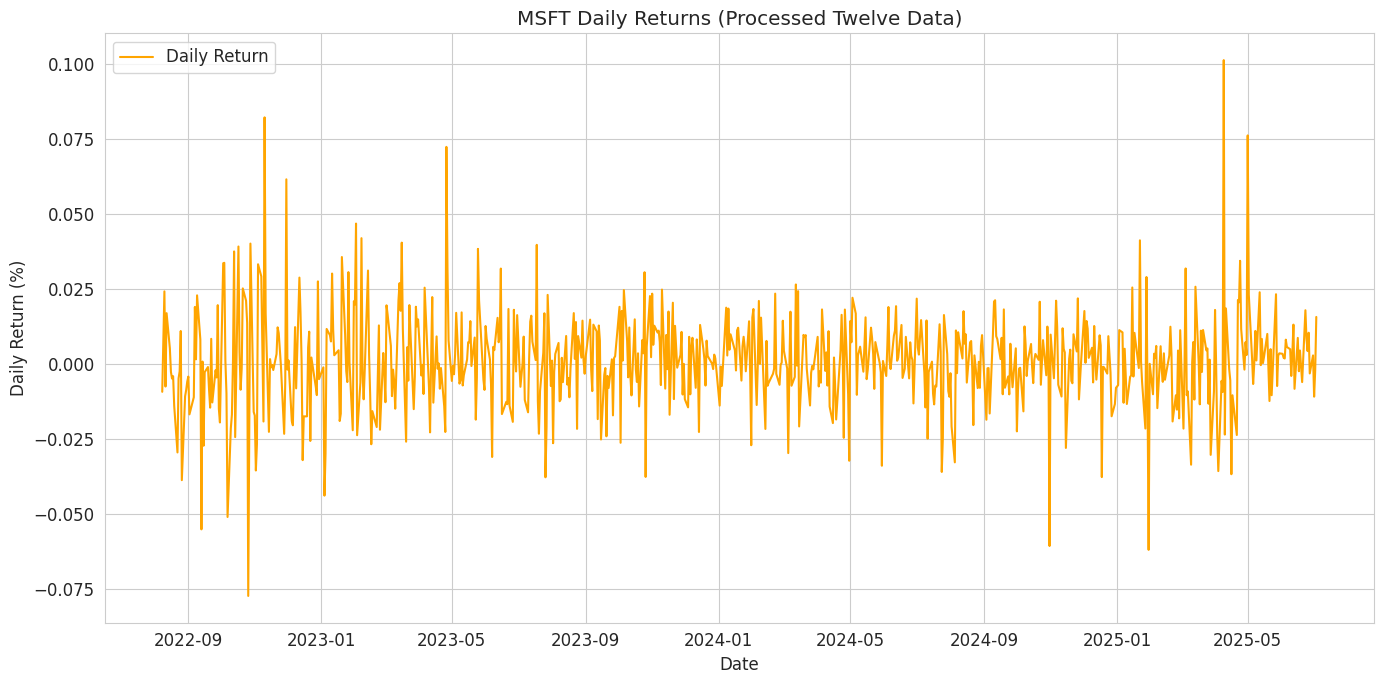

In [8]:
# Cell 8: Basic Visualization - Twelve Data Daily Returns
if not processed_twelvedata_historical_df.empty and 'daily_return' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['daily_return'], label='Daily Return', color='orange')
    plt.title(f'{TARGET_SYMBOL} Daily Returns (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data daily returns for AAPL.")


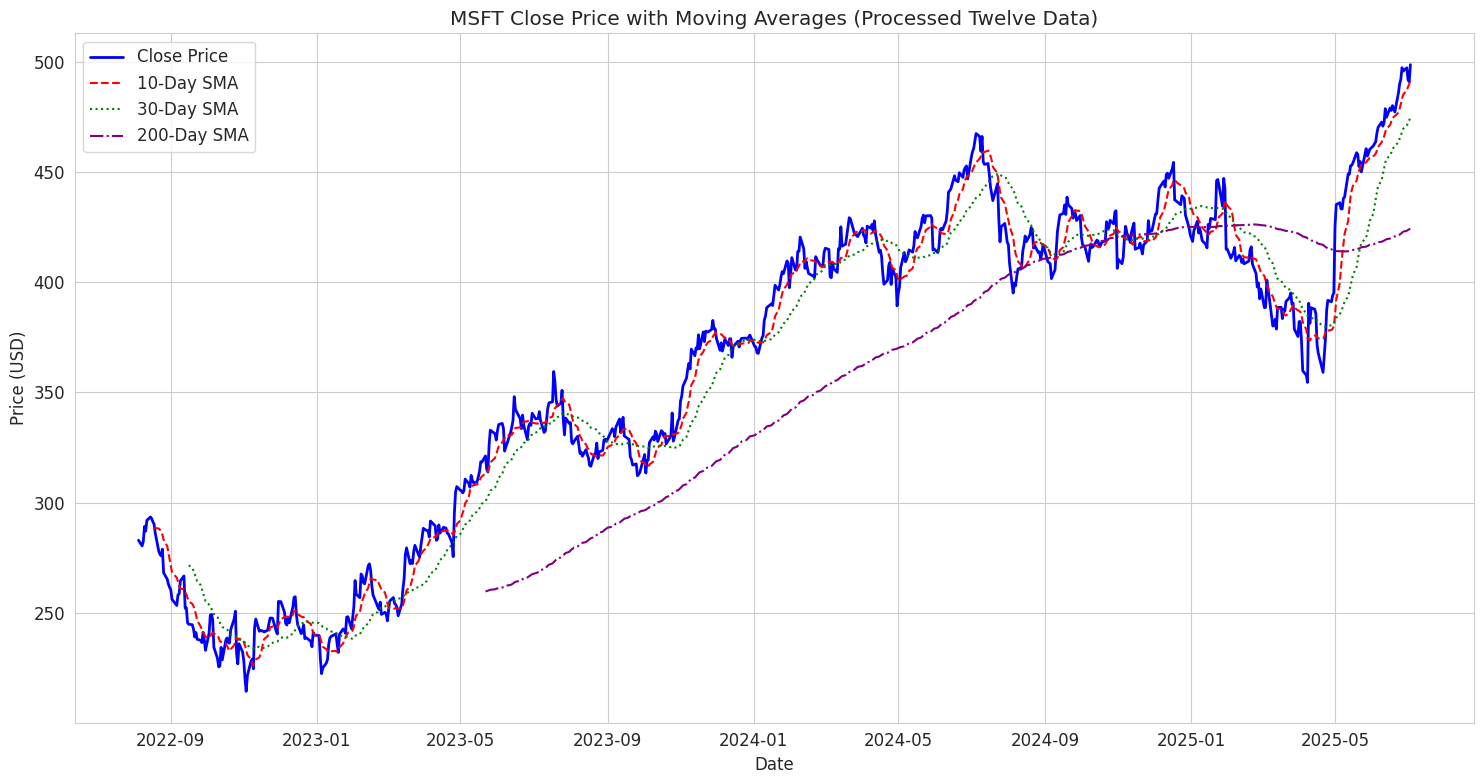

In [9]:
# Cell 9: Calculate and Plot Moving Averages
# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:

    # --- Calculate Simple Moving Averages (SMA) ---
    # SMA 10-day: Short-term trend
    processed_twelvedata_historical_df['SMA_10'] = processed_twelvedata_historical_df['close'].rolling(window=10).mean()

    # SMA 30-day: Medium-term trend
    processed_twelvedata_historical_df['SMA_30'] = processed_twelvedata_historical_df['close'].rolling(window=30).mean()

    # SMA 200-day: Long-term trend (unchanged)
    processed_twelvedata_historical_df['SMA_200'] = processed_twelvedata_historical_df['close'].rolling(window=200).mean()


    # --- Plotting Close Price with Moving Averages ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    
    # Plot SMAs, only if they have enough data points (i.e., not NaN at the beginning)
    if 'SMA_10' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_10'], label='10-Day SMA', color='red', linestyle='--')
    if 'SMA_30' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_30'], label='30-Day SMA', color='green', linestyle=':')
    if 'SMA_200' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_200'], label='200-Day SMA', color='purple', linestyle='-.')

    plt.title(f'{TARGET_SYMBOL} Close Price with Moving Averages (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Moving Averages. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Relative Strength Index (RSI) for Twelve Data Historical (MSFT)...
Added RSI_14 column.
Last 5 rows with new RSI column:
                 close     RSI_14
datetime                         
2025-06-27  495.940000  77.023809
2025-06-30  497.410000  77.728382
2025-07-01  492.049988  69.374625
2025-07-02  491.089996  67.965730
2025-07-03  498.840000  72.772985


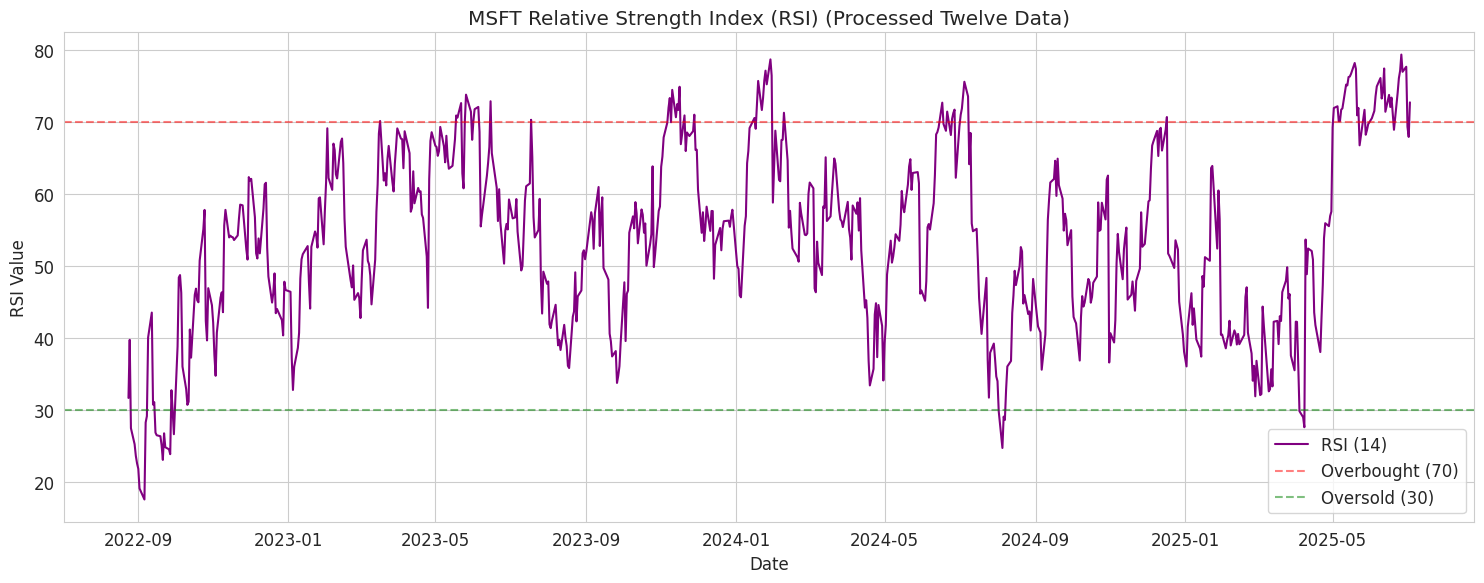

In [10]:
# Cell 10: Calculate and Plot Relative Strength Index (RSI)
# Function to calculate RSI
def calculate_rsi(df, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Get the difference in price
    delta = df['close'].diff()

    # Get positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving average of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{window}'] = rsi
    return df

# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating Relative Strength Index (RSI) for Twelve Data Historical ({TARGET_SYMBOL})...")

    # Calculate RSI with a typical window of 14 days
    processed_twelvedata_historical_df = calculate_rsi(processed_twelvedata_historical_df, window=14)

    print("Added RSI_14 column.")
    print("Last 5 rows with new RSI column:")
    print(processed_twelvedata_historical_df[['close', 'RSI_14']].tail())

    # --- Plotting RSI ---
    plt.figure(figsize=(15, 6))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['RSI_14'], label='RSI (14)', color='purple', linewidth=1.5)
    
    # Add overbought and oversold lines
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')

    plt.title(f'{TARGET_SYMBOL} Relative Strength Index (RSI) (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot RSI. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



Calculating MACD for Twelve Data Historical (MSFT)...
Added MACD_Line, MACD_Signal, and MACD_Histogram columns.
Last 5 rows with new MACD columns:
                 close  MACD_Line  MACD_Signal  MACD_Histogram
datetime                                                      
2025-06-27  495.940000  12.893287    12.488586        0.404701
2025-06-30  497.410000  12.958759    12.582621        0.376139
2025-07-01  492.049988  12.434798    12.553056       -0.118258
2025-07-02  491.089996  11.805999    12.403645       -0.597646
2025-07-03  498.840000  11.797043    12.282324       -0.485281


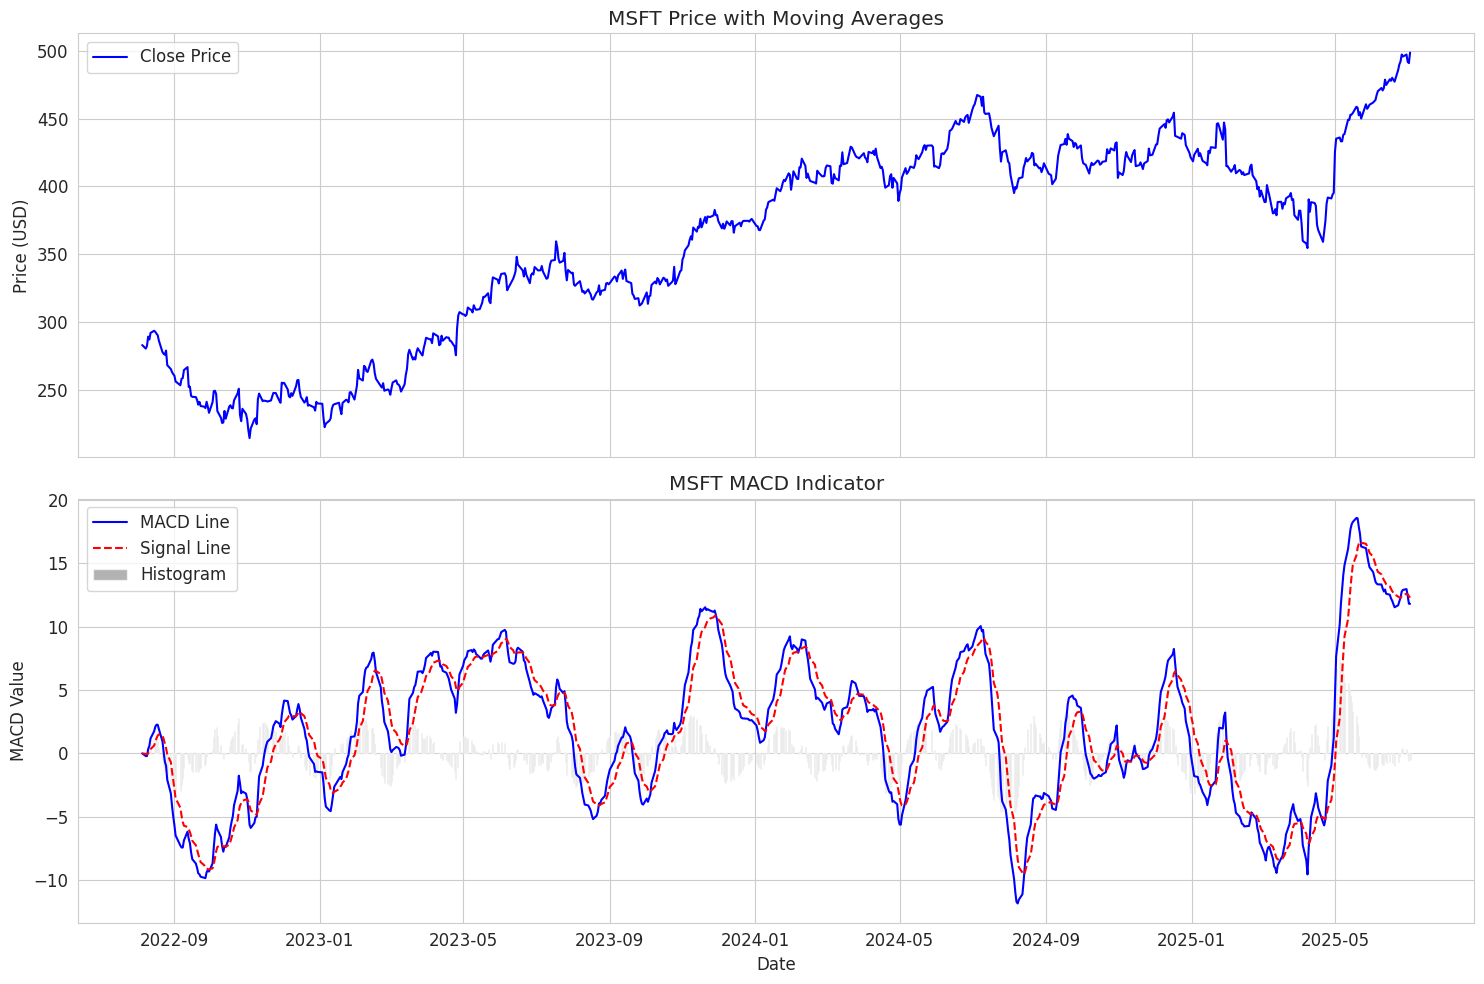

In [11]:
# Cell 11: Calculate and Plot Moving Average Convergence Divergence (MACD)
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates MACD (Moving Average Convergence Divergence) and Signal Line.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Calculate the 12-period EMA
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    # Calculate the 26-period EMA
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate MACD Line
    macd_line = ema_fast - ema_slow

    # Calculate the 9-period EMA of the MACD Line (Signal Line)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    df[f'MACD_Line'] = macd_line
    df[f'MACD_Signal'] = signal_line
    df[f'MACD_Histogram'] = macd_histogram
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating MACD for Twelve Data Historical ({TARGET_SYMBOL})...")

    processed_twelvedata_historical_df = calculate_macd(processed_twelvedata_historical_df)

    print("Added MACD_Line, MACD_Signal, and MACD_Histogram columns.")
    print("Last 5 rows with new MACD columns:")
    print(processed_twelvedata_historical_df[['close', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram']].tail())

    # --- Plotting MACD ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Two subplots for price and MACD
    
    # Plotting Price with Moving Averages (reusing earlier MA calculation if available)
    axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=1.5)
    if 'SMA_20' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    axes[0].set_title(f'{TARGET_SYMBOL} Price with Moving Averages')
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    axes[0].grid(True)

    # Plotting MACD
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Line'], label='MACD Line', color='blue', linewidth=1.5)
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
    
    # Plotting MACD Histogram
    axes[1].bar(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Histogram'], label='Histogram', color='gray', alpha=0.6)

    axes[1].set_title(f'{TARGET_SYMBOL} MACD Indicator')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('MACD Value')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot MACD. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Bollinger Bands for Twelve Data Historical (MSFT)...
Added BB_Middle, BB_Upper, and BB_Lower columns.
Last 5 rows with new Bollinger Bands columns:
                 close   BB_Middle    BB_Upper    BB_Lower
datetime                                                  
2025-06-27  495.940000  476.696998  498.996590  454.397407
2025-06-30  497.410000  478.549499  501.286144  455.812854
2025-07-01  492.049988  480.053498  502.142693  457.964304
2025-07-02  491.089996  481.459498  502.526315  460.392682
2025-07-03  498.840000  483.207998  503.929954  462.486042


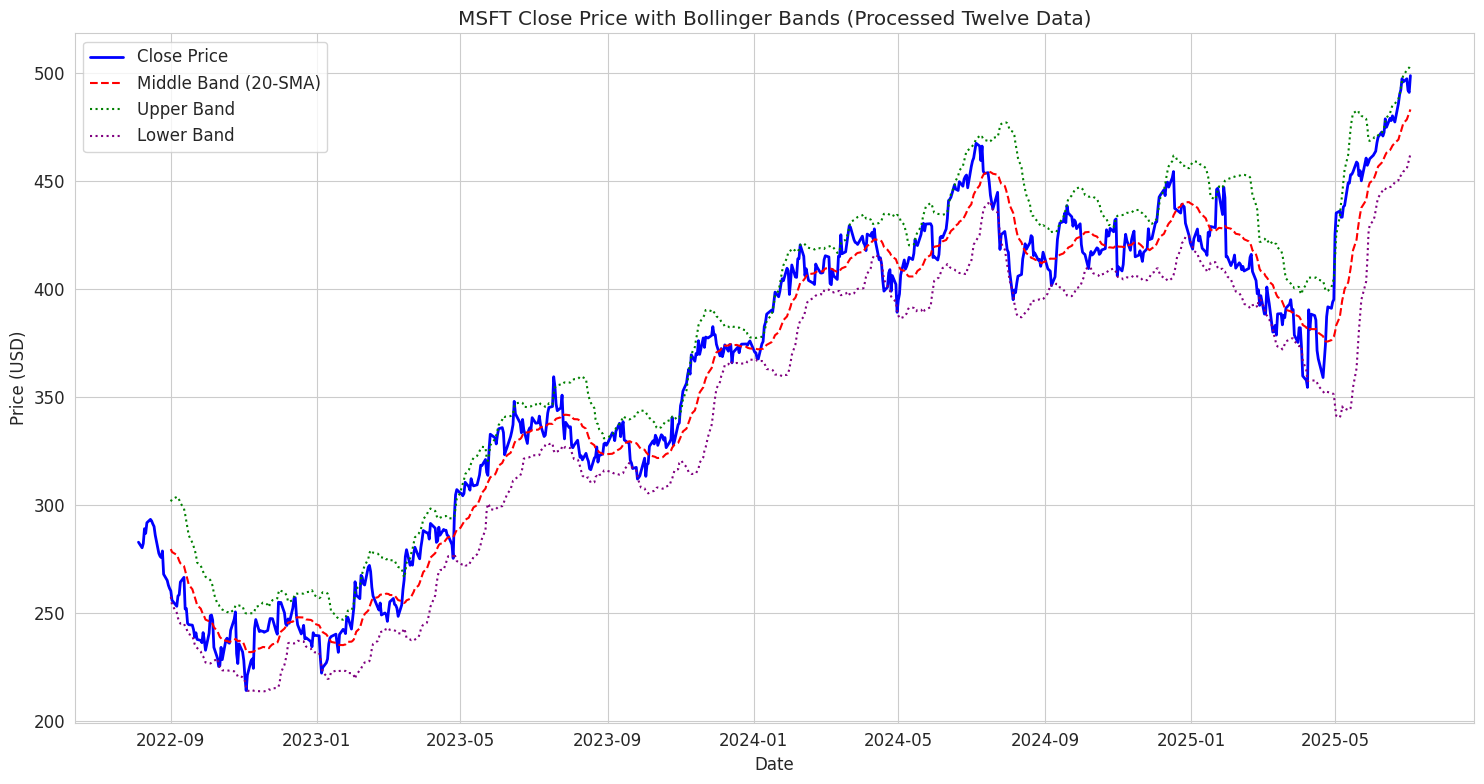

In [12]:
# Cell 12: Calculate and Plot Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Calculates Bollinger Bands (Middle Band, Upper Band, Lower Band).
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Middle Band is the N-period Simple Moving Average
    middle_band = df['close'].rolling(window=window).mean()
    # Standard deviation over N periods
    std_dev = df['close'].rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)

    df[f'BB_Middle'] = middle_band
    df[f'BB_Upper'] = upper_band
    df[f'BB_Lower'] = lower_band
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating Bollinger Bands for Twelve Data Historical ({TARGET_SYMBOL})...")

    processed_twelvedata_historical_df = calculate_bollinger_bands(processed_twelvedata_historical_df)

    print("Added BB_Middle, BB_Upper, and BB_Lower columns.")
    print("Last 5 rows with new Bollinger Bands columns:")
    print(processed_twelvedata_historical_df[['close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].tail())

    # --- Plotting Bollinger Bands ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Middle'], label='Middle Band (20-SMA)', color='red', linestyle='--')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Upper'], label='Upper Band', color='green', linestyle=':')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Lower'], label='Lower Band', color='purple', linestyle=':')

    plt.title(f'{TARGET_SYMBOL} Close Price with Bollinger Bands (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Bollinger Bands. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



In [13]:
# Cell 13: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Ensure the index is a DatetimeIndex before normalizing
    # Assuming 'date' or 'datetime' is the column containing the timestamp/date info
    # If your processed_finnhub_quotes_df already has a datetime index,
    # then the .reset_index() might be converting it back.
    # Let's assume the datetime info is in a column named 'date' or 'datetime'
    # and we want to set it as index and then normalize.

    # For Finnhub data:
    # If 'date' is a column, convert it to datetime and set as index
    if 'date' in processed_finnhub_quotes_df.columns:
        finnhub_daily = processed_finnhub_quotes_df.copy()
        finnhub_daily['date'] = pd.to_datetime(finnhub_daily['date'])
        finnhub_daily = finnhub_daily.set_index('date')
    else:
        # If 'date' is not a column, assume index is already datetime or needs conversion
        finnhub_daily = processed_finnhub_quotes_df.copy()
        if not isinstance(finnhub_daily.index, pd.DatetimeIndex):
            finnhub_daily.index = pd.to_datetime(finnhub_daily.index)

    finnhub_daily = finnhub_daily.set_index(finnhub_daily.index.normalize())


    # For Twelve Data historical data:
    # If 'datetime' is a column, convert it to datetime and set as index
    if 'datetime' in processed_twelvedata_historical_df.columns:
        twelvedata_daily = processed_twelvedata_historical_df.copy()
        twelvedata_daily['datetime'] = pd.to_datetime(twelvedata_daily['datetime'])
        twelvedata_daily = twelvedata_daily.set_index('datetime')
    else:
        # If 'datetime' is not a column, assume index is already datetime or needs conversion
        twelvedata_daily = processed_twelvedata_historical_df.copy()
        if not isinstance(twelvedata_daily.index, pd.DatetimeIndex):
            twelvedata_daily.index = pd.to_datetime(twelvedata_daily.index)

    twelvedata_daily = twelvedata_daily.set_index(twelvedata_daily.index.normalize())


    # Select a few columns for the merged view
    merged_df = pd.merge(
        finnhub_daily[['close', 'high', 'low', 'open', 'symbol', 'spread']],
        twelvedata_daily[['close', 'volume', 'daily_return', 'symbol']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_finnhub', '_twelvedata')
    )
    print(f"\nExample of Merged Finnhub Quotes & Twelve Data Historical for {TARGET_SYMBOL} (first 5 rows):")
    print(merged_df.head())
    print(f"\nMerged Data Info for {TARGET_SYMBOL}:")
    merged_df.info()
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data. Please ensure data collection and transformation ran successfully.")



Example of Merged Finnhub Quotes & Twelve Data Historical for MSFT (first 5 rows):
Empty DataFrame
Columns: [close, high, low, open, symbol_finnhub, spread, td_close, td_volume, daily_return, symbol_twelvedata]
Index: []

Merged Data Info for MSFT:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close              0 non-null      float64
 1   high               0 non-null      float64
 2   low                0 non-null      float64
 3   open               0 non-null      float64
 4   symbol_finnhub     0 non-null      object 
 5   spread             0 non-null      float64
 6   td_close           0 non-null      float64
 7   td_volume          0 non-null      int64  
 8   daily_return       0 non-null      float64
 9   symbol_twelvedata  0 non-null      object 
dtypes: float64(7), int64(1), object(2)
memory usage: 0.0+ bytes



Identifying simple trading signals for MSFT...
  SMA Crossover signals calculated (1=Buy, -1=Sell, using 10/30).
  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).
  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).
  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).
  Combined_Signal_WINDOW (windowed AND, ±3 days) calculated (1=Buy, -1=Sell, using 10/30).

Signal counts for Combined_Signal_WINDOW:
Combined_Signal_WINDOW
0    728
1      2
Name: count, dtype: int64


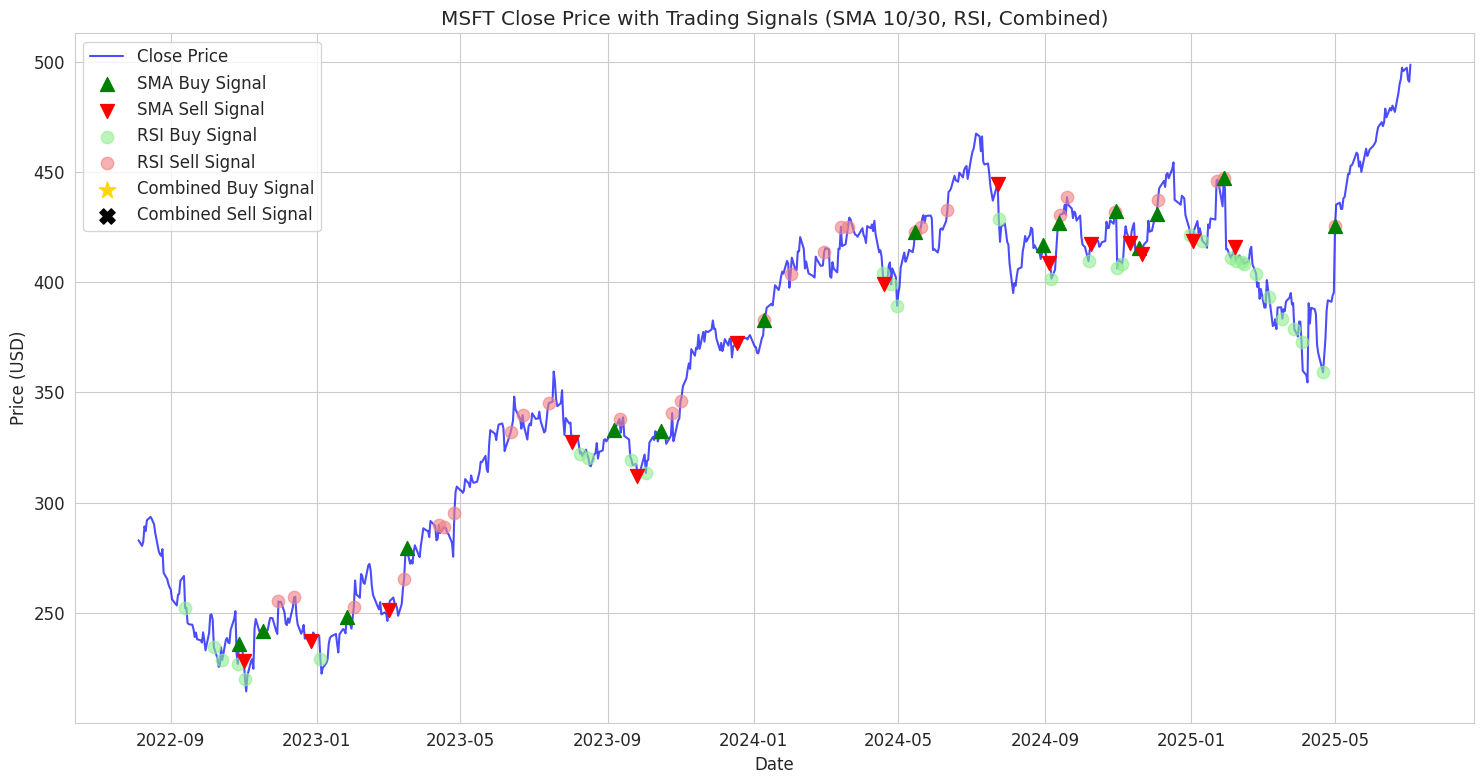

In [14]:
# Cell 14: Identify Simple Trading Signals (with Combined Signal)
# This cell uses the previously calculated indicators to generate basic buy/sell signals.
# This is a starting point; real trading strategies are far more complex.

if not processed_twelvedata_historical_df.empty:
    print(f"\nIdentifying simple trading signals for {TARGET_SYMBOL}...")

    df_signals = processed_twelvedata_historical_df.copy() # Work on a copy to avoid SettingWithCopyWarning

    # --- SMA Crossover Signal ---
    df_signals['SMA_Crossover_Signal'] = 0 # Default to no signal
    if 'SMA_10' in df_signals.columns and 'SMA_30' in df_signals.columns:
        df_signals['SMA_Diff'] = df_signals['SMA_10'] - df_signals['SMA_30']
        df_signals['SMA_Crossover'] = (df_signals['SMA_Diff'].shift(1) < 0) & (df_signals['SMA_Diff'] > 0) # Buy signal
        df_signals['SMA_Crossunder'] = (df_signals['SMA_Diff'].shift(1) > 0) & (df_signals['SMA_Diff'] < 0) # Sell signal
        df_signals.loc[df_signals['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1 # Sell signal
        df_signals.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
        print("  SMA Crossover signals calculated (1=Buy, -1=Sell, using 10/30).")

    # --- RSI Overbought/Oversold Signal (looser: 40/60) ---
    df_signals['RSI_Signal'] = 0 # Default to no signal
    if 'RSI_14' in df_signals.columns:
        df_signals['RSI_Buy_Cross'] = (df_signals['RSI_14'].shift(1) > 40) & (df_signals['RSI_14'] <= 40)
        df_signals['RSI_Sell_Cross'] = (df_signals['RSI_14'].shift(1) < 60) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[df_signals['RSI_Buy_Cross'], 'RSI_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['RSI_Sell_Cross'], 'RSI_Signal'] = -1 # Sell signal
        df_signals.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
        print("  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).")

    # --- Combined Signal (AND) ---
    df_signals['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df_signals.columns and 'RSI_14' in df_signals.columns:
        buy_condition = (df_signals['SMA_Crossover_Signal'] == 1) & (df_signals['RSI_14'] <= 40)
        sell_condition = (df_signals['SMA_Crossover_Signal'] == -1) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[buy_condition, 'Combined_Signal'] = 1
        df_signals.loc[sell_condition, 'Combined_Signal'] = -1
        print("  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).")

    # --- Combined Signal OR (triggers if either SMA or RSI signal fires) ---
    df_signals['Combined_Signal_OR'] = 0
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == 1) | (df_signals['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == -1) | (df_signals['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    print("  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).")

    # --- Combined Signal (Windowed AND, ±3 days) ---
    df_signals['Combined_Signal_WINDOW'] = 0
    window = 3
    sma_buy_idx = df_signals.index[df_signals['SMA_Crossover_Signal'] == 1].tolist()
    rsi_buy_idx = df_signals.index[df_signals['RSI_14'] <= 40].tolist()
    for idx in sma_buy_idx:
        window_range = df_signals.index.get_loc(idx)
        start = max(0, window_range - window)
        end = min(len(df_signals) - 1, window_range + window)
        window_indices = df_signals.index[start:end+1]
        if any(i in rsi_buy_idx for i in window_indices):
            df_signals.at[idx, 'Combined_Signal_WINDOW'] = 1
    sma_sell_idx = df_signals.index[df_signals['SMA_Crossover_Signal'] == -1].tolist()
    rsi_sell_idx = df_signals.index[df_signals['RSI_14'] >= 60].tolist()
    for idx in sma_sell_idx:
        window_range = df_signals.index.get_loc(idx)
        start = max(0, window_range - window)
        end = min(len(df_signals) - 1, window_range + window)
        window_indices = df_signals.index[start:end+1]
        if any(i in rsi_sell_idx for i in window_indices):
            df_signals.at[idx, 'Combined_Signal_WINDOW'] = -1
    print("  Combined_Signal_WINDOW (windowed AND, ±3 days) calculated (1=Buy, -1=Sell, using 10/30).")

    # --- Diagnostic: Show signal counts ---
    print("\nSignal counts for Combined_Signal_WINDOW:")
    print(df_signals['Combined_Signal_WINDOW'].value_counts())

    # --- Plotting Signals on Price Chart (Optional, can be dense) ---
    plt.figure(figsize=(15, 8))
    plt.plot(df_signals.index, df_signals['close'], label='Close Price', color='blue', linewidth=1.5, alpha=0.7)
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == 1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == 1], 
                marker='^', color='green', s=100, label='SMA Buy Signal', zorder=5)
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == -1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == -1], 
                marker='v', color='red', s=100, label='SMA Sell Signal', zorder=5)
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == 1], 
                df_signals['close'][df_signals['RSI_Signal'] == 1], 
                marker='o', color='lightgreen', s=80, alpha=0.6, label='RSI Buy Signal', zorder=4)
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == -1], 
                df_signals['close'][df_signals['RSI_Signal'] == -1], 
                marker='o', color='lightcoral', s=80, alpha=0.6, label='RSI Sell Signal', zorder=4)
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == 1], 
                df_signals['close'][df_signals['Combined_Signal'] == 1], 
                marker='*', color='gold', s=150, label='Combined Buy Signal', zorder=6)
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == -1], 
                df_signals['close'][df_signals['Combined_Signal'] == -1], 
                marker='X', color='black', s=120, label='Combined Sell Signal', zorder=6)
    plt.title(f'{TARGET_SYMBOL} Close Price with Trading Signals (SMA 10/30, RSI, Combined)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nCannot identify trading signals. 'processed_twelvedata_historical_df' is empty.")


     Initial Capital  Final Portfolio Value  Total Trades Executed  \
337            10000           10273.733688                     27   
339            10000           10554.373066                     27   
341            10000           10845.220954                     27   
355            10000           10276.785568                     25   
327            10000           10398.084416                     27   
357            10000           10556.980326                     25   
325            10000           10186.294618                     27   
553            10000           10238.323512                     28   
331            10000           10224.143358                     27   
349            10000           10257.305078                     25   
555            10000           10483.552714                     28   
557            10000           10752.913896                     28   
359            10000           10850.760004                     25   
333            10000

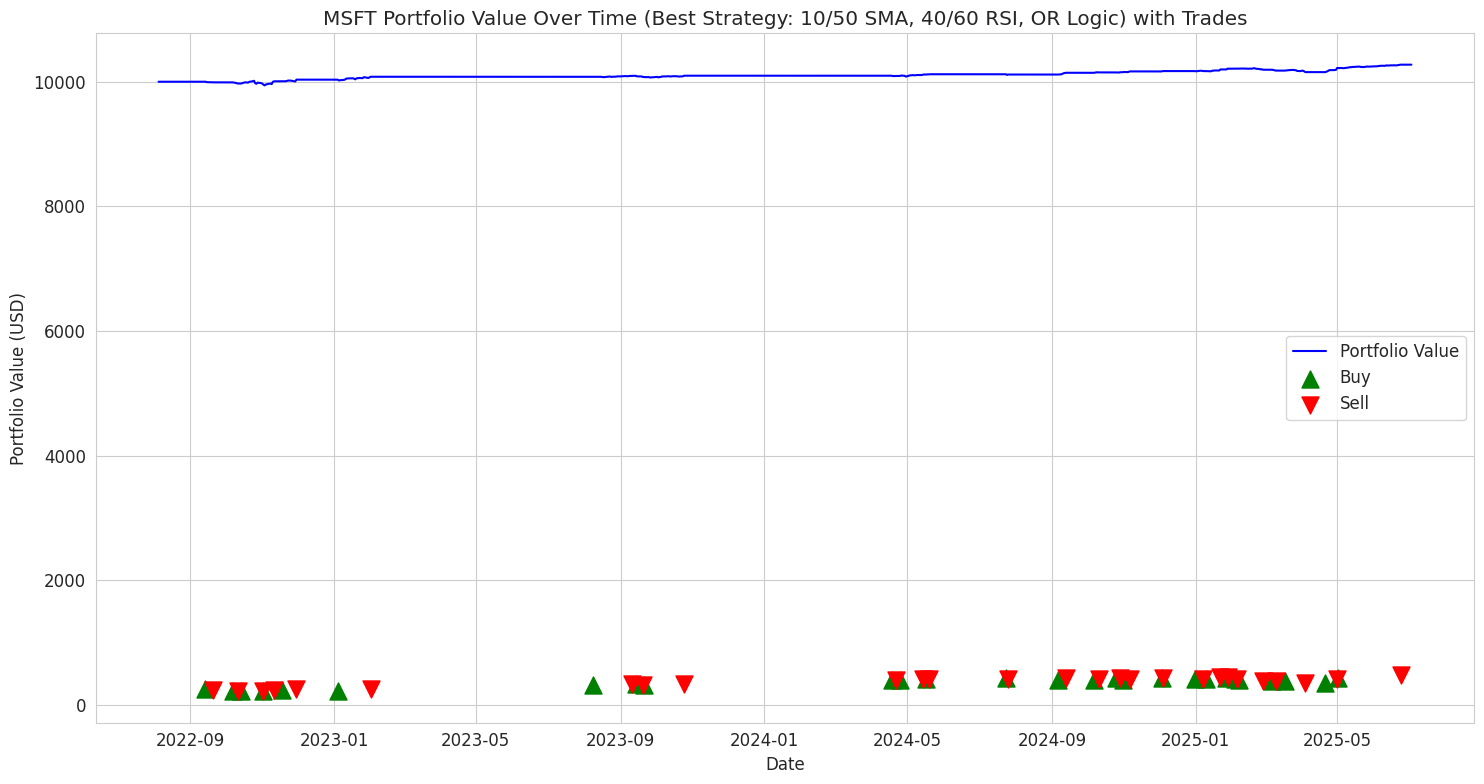

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Backtest Configuration ---
INITIAL_CAPITAL = 10000
STOP_LOSS_PERCENT = 0.05   # 5% stop loss
TAKE_PROFIT_PERCENT = 0.10 # 10% take profit
POSITION_SIZE_PERCENT = 0.10 # 10% of capital per trade (configurable)
TRANSACTION_COST_PERCENT = 0.001 # 0.1% transaction cost per side (buy & sell)
# You can change these values here to experiment with different parameters.

# --- Helper Functions for Indicator Calculations ---
def calculate_sma(df, short_period, long_period):
    df = df.copy()
    df[f'SMA_{short_period}'] = df['close'].rolling(window=short_period).mean()
    df[f'SMA_{long_period}'] = df['close'].rolling(window=long_period).mean()
    return df

def calculate_rsi(df, window=14):
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df[f'RSI_{window}'] = rsi
    return df

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    df['MACD_Line'] = macd_line
    df['MACD_Signal'] = signal_line
    df['MACD_Histogram'] = macd_histogram
    return df

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df = df.copy()
    middle_band = df['close'].rolling(window=window).mean()
    std_dev = df['close'].rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    df['BB_Middle'] = middle_band
    df['BB_Upper'] = upper_band
    df['BB_Lower'] = lower_band
    return df

def calculate_signals(df, sma_short, sma_long, rsi_oversold, rsi_overbought):
    df = df.copy()
    # SMA Crossover
    df['SMA_Crossover_Signal'] = 0
    if f'SMA_{sma_short}' in df.columns and f'SMA_{sma_long}' in df.columns:
        df['SMA_Diff'] = df[f'SMA_{sma_short}'] - df[f'SMA_{sma_long}']
        df['SMA_Crossover'] = (df['SMA_Diff'].shift(1) < 0) & (df['SMA_Diff'] > 0)
        df['SMA_Crossunder'] = (df['SMA_Diff'].shift(1) > 0) & (df['SMA_Diff'] < 0)
        df.loc[df['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1
        df.loc[df['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1
        df.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
    # RSI Signal
    df['RSI_Signal'] = 0
    if 'RSI_14' in df.columns:
        df['RSI_Buy_Cross'] = (df['RSI_14'].shift(1) > rsi_oversold) & (df['RSI_14'] <= rsi_oversold)
        df['RSI_Sell_Cross'] = (df['RSI_14'].shift(1) < rsi_overbought) & (df['RSI_14'] >= rsi_overbought)
        df.loc[df['RSI_Buy_Cross'], 'RSI_Signal'] = 1
        df.loc[df['RSI_Sell_Cross'], 'RSI_Signal'] = -1
        df.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
    # Combined Signals
    df['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df.columns and 'RSI_14' in df.columns:
        buy_condition = (df['SMA_Crossover_Signal'] == 1) & (df['RSI_14'] <= rsi_oversold)
        sell_condition = (df['SMA_Crossover_Signal'] == -1) & (df['RSI_14'] >= rsi_overbought)
        df.loc[buy_condition, 'Combined_Signal'] = 1
        df.loc[sell_condition, 'Combined_Signal'] = -1
    df['Combined_Signal_OR'] = 0
    df.loc[(df['SMA_Crossover_Signal'] == 1) | (df['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df.loc[(df['SMA_Crossover_Signal'] == -1) | (df['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    return df

# --- Backtest Function ---
def run_backtest(df_signals, initial_capital, stop_loss_percent, take_profit_percent, position_size_percent, symbol_name, sma_short, sma_long, rsi_oversold, rsi_overbought, use_or_logic, transaction_cost_percent):
    df = df_signals.copy()
    signal_col = 'Combined_Signal_OR' if use_or_logic else 'Combined_Signal'
    shares_held = 0
    capital = initial_capital
    trade_details = []
    current_buy_price = 0
    portfolio_value = [initial_capital]
    daily_returns_strategy = []
    for i in range(1, len(df)):
        current_close = df['close'].iloc[i]
        current_date = df.index[i]
        current_day_portfolio_value = capital + (shares_held * current_close) if shares_held > 0 else capital
        if len(portfolio_value) > 0 and portfolio_value[-1] != 0:
            daily_return_for_day = (current_day_portfolio_value / portfolio_value[-1]) - 1
            daily_returns_strategy.append(daily_return_for_day)
        else:
            daily_returns_strategy.append(0)
        # Stop-Loss/Take-Profit
        if shares_held > 0 and current_buy_price > 0:
            stop_loss_price = current_buy_price * (1 - stop_loss_percent)
            take_profit_price = current_buy_price * (1 + take_profit_percent)
            revenue = shares_held * current_close
            trade_cost = revenue * transaction_cost_percent
            if current_close <= stop_loss_price:
                trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
                capital += (revenue - trade_cost)
                trade_details.append({'date': current_date, 'type': 'Sell (SL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
            elif current_close >= take_profit_price:
                trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
                capital += (revenue - trade_cost)
                trade_details.append({'date': current_date, 'type': 'Sell (TP)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
        # Signal logic
        signal = df[signal_col].iloc[i]
        if signal == 1 and shares_held == 0:
            capital_to_allocate = capital * position_size_percent
            shares_to_buy = int(capital_to_allocate / current_close)
            if shares_to_buy == 0 and capital >= current_close:
                shares_to_buy = 1
            if shares_to_buy > 0:
                cost = shares_to_buy * current_close
                trade_cost = cost * transaction_cost_percent
                capital -= (cost + trade_cost)
                shares_held = shares_to_buy
                current_buy_price = current_close
                trade_details.append({'date': current_date, 'type': 'Buy', 'price': current_close, 'shares': shares_held, 'profit_loss': -cost - trade_cost})
        elif signal == -1 and shares_held > 0:
            revenue = shares_held * current_close
            trade_cost = revenue * transaction_cost_percent
            trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
            capital += (revenue - trade_cost)
            trade_details.append({'date': current_date, 'type': 'Sell (SIGNAL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
            shares_held = 0
            current_buy_price = 0
        portfolio_value.append(capital + (shares_held * current_close))
    # Final close
    if shares_held > 0:
        final_close = df['close'].iloc[-1]
        revenue = shares_held * final_close
        trade_cost = revenue * transaction_cost_percent
        trade_profit = ((final_close - current_buy_price) * shares_held) - trade_cost
        capital += (revenue - trade_cost)
        trade_details.append({'date': df.index[-1], 'type': 'Sell (Final)', 'price': final_close, 'shares': shares_held, 'profit_loss': trade_profit})
        shares_held = 0
    final_portfolio_value = capital
    total_return_usd = final_portfolio_value - initial_capital
    total_return_percent = (total_return_usd / initial_capital) * 100
    winning_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] > 0]
    losing_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] < 0]
    total_trades_executed = len(winning_trades) + len(losing_trades)
    win_rate = (len(winning_trades) / total_trades_executed * 100) if total_trades_executed > 0 else 0
    avg_win = (sum(t['profit_loss'] for t in winning_trades) / len(winning_trades)) if winning_trades else 0
    avg_loss = (sum(t['profit_loss'] for t in losing_trades) / len(losing_trades)) if losing_trades else 0
    if len(daily_returns_strategy) > 0:
        daily_returns_series = pd.Series(daily_returns_strategy)
        cumulative_returns = (1 + daily_returns_series).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        annualization_factor = np.sqrt(252)
        sharpe_ratio = (daily_returns_series.mean() / daily_returns_series.std()) * annualization_factor if daily_returns_series.std() != 0 else None
        downside_returns = daily_returns_series[daily_returns_series < 0]
        if not downside_returns.empty and downside_returns.std() != 0:
            downside_deviation = downside_returns.std()
            annualized_downside_deviation = downside_deviation * annualization_factor
            sortino_ratio = (daily_returns_series.mean() / annualized_downside_deviation) * annualization_factor
        else:
            sortino_ratio = None
    else:
        max_drawdown = None
        sharpe_ratio = None
        sortino_ratio = None
    results_summary = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Trades Executed': total_trades_executed,
        'Winning Trades': len(winning_trades),
        'Losing Trades': len(losing_trades),
        'Win Rate (%)': win_rate,
        'Average Win (USD)': avg_win,
        'Average Loss (USD)': avg_loss,
        'Total Return (USD)': total_return_usd,
        'Total Return (%)': total_return_percent,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Sortino Ratio (Annualized)': sortino_ratio
    }
    return results_summary, trade_details, portfolio_value

# --- Parameter Grids ---
sma_short_periods = [10, 20, 30]
sma_long_periods = [30, 50, 60]
rsi_oversold_thresholds = [30, 40]
rsi_overbought_thresholds = [60, 70]
sl_percentages = [0.03, 0.05, 0.07]
tp_percentages = [0.08, 0.10, 0.12]
position_sizes = [0.05, 0.10, 0.15]
logic_types = [False, True]  # False=AND, True=OR

all_optimization_results = []

for s_short in sma_short_periods:
    for s_long in sma_long_periods:
        if s_short >= s_long:
            continue
        for rsi_os in rsi_oversold_thresholds:
            for rsi_ob in rsi_overbought_thresholds:
                for sl_percent in sl_percentages:
                    for tp_percent in tp_percentages:
                        for pos_size in position_sizes:
                            for use_or_logic in logic_types:
                                if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
                                    df = processed_twelvedata_historical_df.copy()
                                    df = calculate_sma(df, s_short, s_long)
                                    df = calculate_rsi(df, window=14)
                                    df = calculate_macd(df)
                                    df = calculate_bollinger_bands(df)
                                    df = calculate_signals(df, s_short, s_long, rsi_os, rsi_ob)
                                    current_results, _, _ = run_backtest(
                                        df_signals=df,
                                        initial_capital=INITIAL_CAPITAL,
                                        stop_loss_percent=sl_percent,
                                        take_profit_percent=tp_percent,
                                        position_size_percent=pos_size,
                                        symbol_name=TARGET_SYMBOL,
                                        sma_short=s_short,
                                        sma_long=s_long,
                                        rsi_oversold=rsi_os,
                                        rsi_overbought=rsi_ob,
                                        use_or_logic=use_or_logic,
                                        transaction_cost_percent=TRANSACTION_COST_PERCENT
                                    )
                                    current_results['SMA Short'] = s_short
                                    current_results['SMA Long'] = s_long
                                    current_results['RSI Oversold'] = rsi_os
                                    current_results['RSI Overbought'] = rsi_ob
                                    current_results['SL %'] = sl_percent
                                    current_results['TP %'] = tp_percent
                                    current_results['Position Size %'] = pos_size
                                    current_results['Logic'] = 'OR' if use_or_logic else 'AND'
                                    all_optimization_results.append(current_results)

# --- Present Results ---
results_df = pd.DataFrame(all_optimization_results)
results_df_sorted = results_df.sort_values(by=['Sharpe Ratio (Annualized)', 'Total Return (%)'], ascending=[False, False])

# Display top 20 strategies
print(results_df_sorted.head(20))

# --- Identify and Visualize Best Strategy ---
if not results_df_sorted.empty:
    best_strategy_params = results_df_sorted.iloc[0]
    print("\n--- Best Performing Strategy Parameters ---")
    print(best_strategy_params)

    # Extract best parameters
    best_s_short = int(best_strategy_params['SMA Short'])
    best_s_long = int(best_strategy_params['SMA Long'])
    best_rsi_os = int(best_strategy_params['RSI Oversold'])
    best_rsi_ob = int(best_strategy_params['RSI Overbought'])
    best_sl_percent = float(best_strategy_params['SL %'])
    best_tp_percent = float(best_strategy_params['TP %'])
    best_pos_size = float(best_strategy_params['Position Size %'])
    best_use_or_logic = True if best_strategy_params['Logic'] == 'OR' else False

    # Re-calculate indicators and signals for the best strategy
    df_for_best_plot = processed_twelvedata_historical_df.copy()
    df_for_best_plot = calculate_sma(df_for_best_plot, best_s_short, best_s_long)
    df_for_best_plot = calculate_rsi(df_for_best_plot, window=14)
    df_for_best_plot = calculate_macd(df_for_best_plot)
    df_for_best_plot = calculate_bollinger_bands(df_for_best_plot)
    df_for_best_plot = calculate_signals(df_for_best_plot, best_s_short, best_s_long, best_rsi_os, best_rsi_ob)

    # Re-run backtest for the best strategy
    best_summary, best_trade_details, best_portfolio_value = run_backtest(
        df_signals=df_for_best_plot,
        initial_capital=INITIAL_CAPITAL,
        stop_loss_percent=best_sl_percent,
        take_profit_percent=best_tp_percent,
        position_size_percent=best_pos_size,
        symbol_name=TARGET_SYMBOL,
        sma_short=best_s_short,
        sma_long=best_s_long,
        rsi_oversold=best_rsi_os,
        rsi_overbought=best_rsi_ob,
        use_or_logic=best_use_or_logic,
        transaction_cost_percent=TRANSACTION_COST_PERCENT
    )

    # --- Plotting Best Strategy Portfolio Value with Trades ---
    plt.figure(figsize=(15, 8))
    # Ensure x and y are the same length for plotting
    plt.plot(df_for_best_plot.index, best_portfolio_value[:len(df_for_best_plot.index)], label='Portfolio Value', color='blue')

    buy_dates = [t['date'] for t in best_trade_details if t['type'] == 'Buy']
    buy_prices = [t['price'] for t in best_trade_details if t['type'] == 'Buy']
    sell_dates = [t['date'] for t in best_trade_details if t['type'].startswith('Sell')]
    sell_prices = [t['price'] for t in best_trade_details if t['type'].startswith('Sell')]

    plt.scatter(buy_dates, buy_prices, marker='^', color='green', s=150, label='Buy', zorder=5)
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', s=150, label='Sell', zorder=5)

    plot_title_logic = 'OR' if best_use_or_logic else 'AND'
    plt.title(f'{TARGET_SYMBOL} Portfolio Value Over Time (Best Strategy: {best_s_short}/{best_s_long} SMA, {best_rsi_os}/{best_rsi_ob} RSI, {plot_title_logic} Logic) with Trades')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo strategies found to optimize.")


In [29]:
# Parameter Sweep: Backtest for different stop-loss/take-profit thresholds
import itertools
sweep_results = []
sl_values = [0.03, 0.05, 0.07]
tp_values = [0.07, 0.10, 0.15]
for sl, tp in itertools.product(sl_values, tp_values):
    capital = 10000
    shares = 0
    buy_price = 0
    trade_log = []
    for i in range(1, len(df_signals)):
        close = df_signals['close'].iloc[i]
        signal = df_signals['Combined_Signal_OR'].iloc[i]
        if shares > 0:
            if close <= buy_price * (1 - sl):
                capital += shares * close
                trade_log.append({'type': 'Sell (SL)', 'price': close})
                shares = 0
            elif close >= buy_price * (1 + tp):
                capital += shares * close
                trade_log.append({'type': 'Sell (TP)', 'price': close})
                shares = 0
        if signal == 1 and shares == 0:
            shares = int(capital / close)
            if shares > 0:
                capital -= shares * close
                buy_price = close
                trade_log.append({'type': 'Buy', 'price': close})
        elif signal == -1 and shares > 0:
            capital += shares * close
            trade_log.append({'type': 'Sell', 'price': close})
            shares = 0
    if shares > 0:
        capital += shares * df_signals['close'].iloc[-1]
    total_return = (capital - 10000) / 10000 * 100
    sweep_results.append({'Stop Loss %': sl*100, 'Take Profit %': tp*100, 'Final Value': capital, 'Total Return %': total_return, 'Trades': len(trade_log)})
sweep_df = pd.DataFrame(sweep_results)
display(sweep_df.sort_values('Total Return %', ascending=False))

# For Twelve Data historical data:
twelvedata_daily = processed_twelvedata_historical_df.copy()
if 'datetime' in twelvedata_daily.columns:
    twelvedata_daily['datetime'] = pd.to_datetime(twelvedata_daily['datetime'])
    twelvedata_daily = twelvedata_daily.set_index('datetime')
elif not isinstance(twelvedata_daily.index, pd.DatetimeIndex):
    twelvedata_daily.index = pd.to_datetime(twelvedata_daily.index)
twelvedata_daily = twelvedata_daily.set_index(twelvedata_daily.index.normalize())

# Cell 16: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Ensure the index is a DatetimeIndex before normalizing

    # For Finnhub data:
    finnhub_df_temp = processed_finnhub_quotes_df.copy()
    if 'fetch_timestamp' in finnhub_df_temp.columns:
        finnhub_df_temp['fetch_timestamp'] = pd.to_datetime(finnhub_df_temp['fetch_timestamp'])
        finnhub_df_temp = finnhub_df_temp.set_index('fetch_timestamp')
    elif not isinstance(finnhub_df_temp.index, pd.DatetimeIndex):
        finnhub_df_temp.index = pd.to_datetime(finnhub_df_temp.index)

    # --- NEW: Aggregate Finnhub data to daily ---
    # Group by symbol and resample to daily.
    # Take the first 'open', max 'high', min 'low', last 'close', and sum 'volume' (if available)
    # For simplicity, we'll use the 'close' from Finnhub, and the 'symbol'
    # If you have volume in Finnhub, you'd add it to the aggregation.
    finnhub_daily_aggregated = finnhub_df_temp.groupby('symbol').resample('D').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'prev_close': 'last', # Keep prev_close if needed
        'spread': 'mean' # Or sum, depending on how you define daily spread
    }).dropna() # Drop days where no data was available after resampling

    # Reset index to handle the MultiIndex (symbol, date) properly
    finnhub_daily = finnhub_daily_aggregated.reset_index()
    # Now 'fetch_timestamp' should be a column after reset_index
    finnhub_daily['fetch_timestamp'] = pd.to_datetime(finnhub_daily['fetch_timestamp'])
    # Normalize the datetime and set as index
    finnhub_daily['normalized_date'] = finnhub_daily['fetch_timestamp'].dt.normalize()
    finnhub_daily = finnhub_daily.set_index('normalized_date')

    # For Twelve Data historical data:
    twelvedata_daily = processed_twelvedata_historical_df.copy()
    if 'datetime' in twelvedata_daily.columns:
        twelvedata_daily['datetime'] = pd.to_datetime(twelvedata_daily['datetime'])
        twelvedata_daily = twelvedata_daily.set_index('datetime')
    elif not isinstance(twelvedata_daily.index, pd.DatetimeIndex):
        twelvedata_daily.index = pd.to_datetime(twelvedata_daily.index)
    twelvedata_daily = twelvedata_daily.set_index(twelvedata_daily.index.normalize())

    # Filter both DataFrames by TARGET_SYMBOL for consistent merging
    print(f"\n--- Filtering DataFrames by TARGET_SYMBOL: {TARGET_SYMBOL} ---")
    
    # Filter Finnhub data
    finnhub_daily_filtered = finnhub_daily[finnhub_daily['symbol'] == TARGET_SYMBOL].copy()
    print(f"Finnhub data after filtering by {TARGET_SYMBOL}: {len(finnhub_daily_filtered)} rows")
    
    # Filter Twelve Data
    twelvedata_daily_filtered = twelvedata_daily[twelvedata_daily['symbol'] == TARGET_SYMBOL].copy()
    print(f"Twelve Data after filtering by {TARGET_SYMBOL}: {len(twelvedata_daily_filtered)} rows")
    
    # Pre-merge check: ensure both filtered DataFrames have data
    if finnhub_daily_filtered.empty:
        print(f"WARNING: No Finnhub data found for symbol {TARGET_SYMBOL} after filtering!")
    if twelvedata_daily_filtered.empty:
        print(f"WARNING: No Twelve Data found for symbol {TARGET_SYMBOL} after filtering!")
    
    if not finnhub_daily_filtered.empty and not twelvedata_daily_filtered.empty:
        print(f"Both DataFrames have data for {TARGET_SYMBOL}, proceeding with merge...")
    else:
        print(f"Cannot merge: insufficient data for {TARGET_SYMBOL} in one or both DataFrames")

    # --- KEEP THESE DEBUGGING PRINTS FOR NOW ---
    print("\n--- Debugging Merge DataFrames (After Filtering) ---")
    print("finnhub_daily_filtered head:")
    print(finnhub_daily_filtered.head())
    print("\nfinnhub_daily_filtered tail:")
    print(finnhub_daily_filtered.tail())
    print("\nfinnhub_daily_filtered info:")
    finnhub_daily_filtered.info()

    print("\n\ntwelvedata_daily_filtered head:")
    print(twelvedata_daily_filtered.head())
    print("\ntwelvedata_daily_filtered tail:")
    print(twelvedata_daily_filtered.tail())
    print("\ntwelvedata_daily_filtered info:")
    twelvedata_daily_filtered.info()
    print("--- End Debugging Merge DataFrames ---\n")
    # --- END DEBUGGING PRINTS ---

    # Merge the filtered DataFrames
    if not finnhub_daily_filtered.empty and not twelvedata_daily_filtered.empty:
        # Note: After filtering by symbol, we can exclude 'symbol' from the merge columns
        # since all rows will have the same symbol value
        merged_df = pd.merge(
            finnhub_daily_filtered[['close', 'high', 'low', 'open', 'spread']],
            twelvedata_daily_filtered[['close', 'volume', 'daily_return']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
            left_index=True,
            right_index=True,
            how='inner',
            suffixes=('_finnhub', '_twelvedata')
        )
        print(f"\nExample of Merged Finnhub Quotes & Twelve Data Historical for {TARGET_SYMBOL} (first 5 rows):")
        print(merged_df.head())
        print(f"\nMerged Data Info for {TARGET_SYMBOL}:")
        merged_df.info()
        print(f"\nMerged Data Shape: {merged_df.shape}")
        
        # Show date range of merged data
        if not merged_df.empty:
            print(f"Date range of merged data: {merged_df.index.min()} to {merged_df.index.max()}")
        else:
            print("WARNING: Merged DataFrame is empty - no matching dates between data sources")
    else:
        print(f"Skipping merge due to insufficient data for {TARGET_SYMBOL}")
        merged_df = pd.DataFrame()  # Create empty DataFrame to avoid errors
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data. Please ensure data collection and transformation ran successfully.")

Stop Loss %  Take Profit %   Final Value  Total Return %  Trades
3          5.0            7.0  16684.375826       66.843758      54
2          3.0           15.0  15592.576384       55.925764      52
0          3.0            7.0  15540.356548       55.403565      58
4          5.0           10.0  15121.096164       51.210962      50
5          5.0           15.0  15042.845754       50.428458      48
6          7.0            7.0  14679.986288       46.799863      52
1          3.0           10.0  14560.447484       45.604475      54
8          7.0           15.0  14482.256176       44.822562      46
7          7.0           10.0  13565.427204       35.654272      48


--- Filtering DataFrames by TARGET_SYMBOL: MSFT ---
Finnhub data after filtering by MSFT: 1 rows
Twelve Data after filtering by MSFT: 730 rows
Both DataFrames have data for MSFT, proceeding with merge...

--- Debugging Merge DataFrames (After Filtering) ---
finnhub_daily_filtered head:
                symbol fetch_timestamp    open    high     low   close  \
normalized_date                                                          
2025-07-05        MSFT      2025-07-05  493.81  500.13  493.44  498.84   

                 prev_close  spread  
normalized_date                      
2025-07-05           491.09    6.69  

finnhub_daily_filtered tail:
                symbol fetch_timestamp    open    high     low   close  \
normalized_date                                                          
2025-07-05        MSFT      2025-07-05  493.81  500.13  493.44  498.84   

                 prev_close  spread  
normalized_date                      
2025-07-05           491.09    6.69  

finnhub

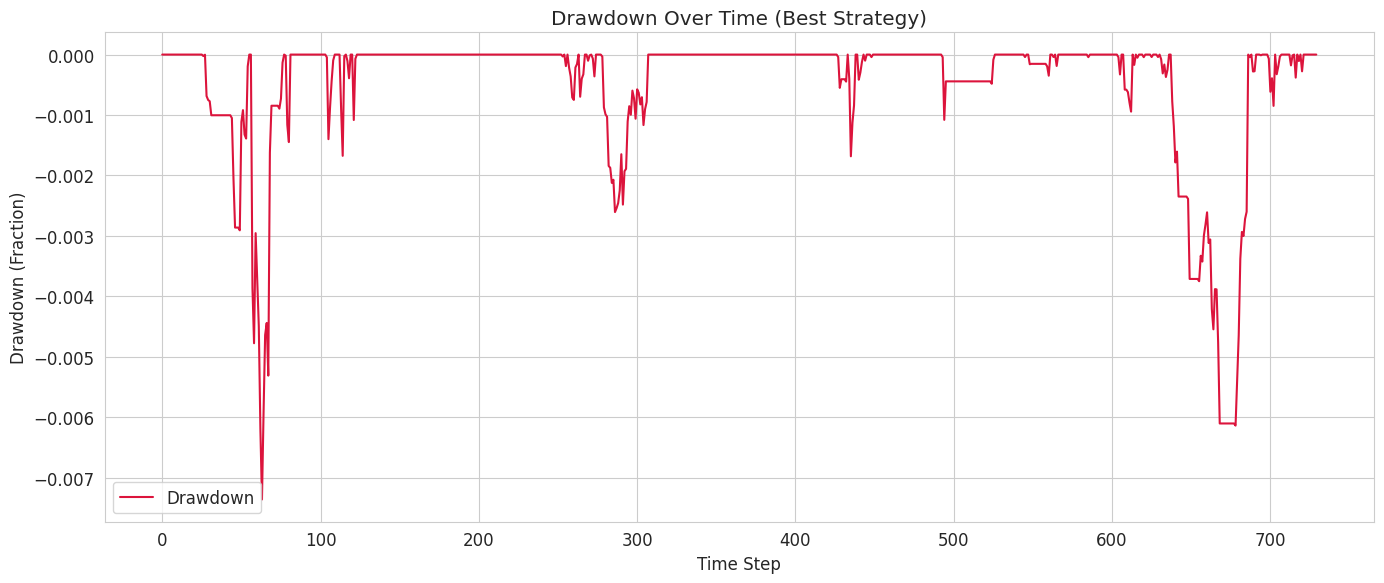

In [17]:
# Plot drawdowns
import pandas as pd
import matplotlib.pyplot as plt

# Use best_portfolio_value from the best strategy backtest if available
if 'best_portfolio_value' in globals() and best_portfolio_value is not None and len(best_portfolio_value) > 1:
    portfolio_series = pd.Series(best_portfolio_value)
    daily_returns_series = portfolio_series.pct_change().fillna(0)
    cumulative_returns = (1 + daily_returns_series).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    plt.figure(figsize=(14, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown', color='crimson')
    plt.title('Drawdown Over Time (Best Strategy)')
    plt.xlabel('Time Step')
    plt.ylabel('Drawdown (Fraction)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Drawdown plot unavailable: best_portfolio_value not found. Please run the backtest cell first.")

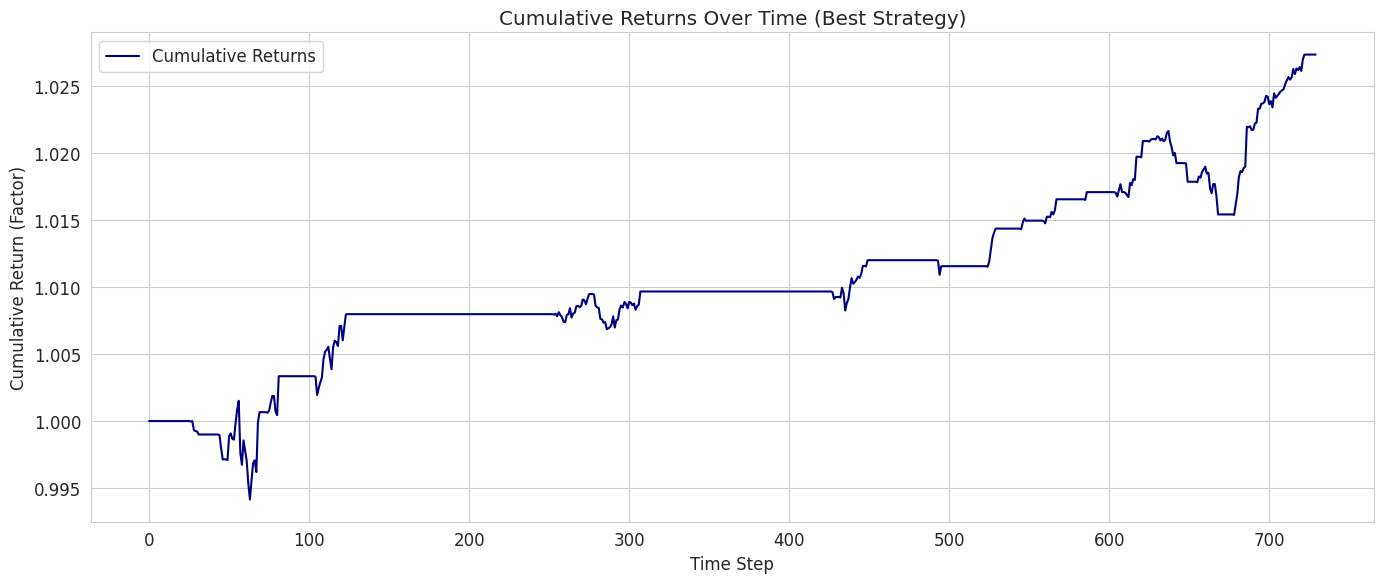

In [18]:
# Plot cumulative returns
import pandas as pd
import matplotlib.pyplot as plt

# Use best_portfolio_value from the best strategy backtest if available
if 'best_portfolio_value' in globals() and best_portfolio_value is not None and len(best_portfolio_value) > 1:
    portfolio_series = pd.Series(best_portfolio_value)
    daily_returns_series = portfolio_series.pct_change().fillna(0)
    cumulative_returns = (1 + daily_returns_series).cumprod()
    plt.figure(figsize=(14, 6))
    plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns', color='navy')
    plt.title('Cumulative Returns Over Time (Best Strategy)')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Return (Factor)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Cumulative returns plot unavailable: best_portfolio_value not found. Please run the backtest cell first.")

In [19]:
# Display trade metrics as a formatted table
import pandas as pd

# Use best_summary from the best strategy backtest if available
if 'results_summary' in globals():
    metrics_df = pd.DataFrame([results_summary]).T
    metrics_df.columns = ['Value']
    display(metrics_df)
elif 'best_summary' in globals():
    metrics_df = pd.DataFrame([best_summary]).T
    metrics_df.columns = ['Value']
    display(metrics_df)
else:
    print("Trade metrics unavailable: results_summary or best_summary not found. Please run the backtest cell first.")

Value
Initial Capital             10000.000000
Final Portfolio Value       10273.733688
Total Trades Executed          27.000000
Winning Trades                 18.000000
Losing Trades                   9.000000
Win Rate (%)                   66.666667
Average Win (USD)              22.840104
Average Loss (USD)            -14.050336
Total Return (USD)            273.733688
Total Return (%)                2.737337
Max Drawdown (%)               -0.727110
Sharpe Ratio (Annualized)       1.522099
Sortino Ratio (Annualized)      0.074784

In [20]:
# Export trade log to CSV
import os
import pandas as pd

# Use best_trade_details from the best strategy backtest if available
if 'trade_details' in globals():
    trade_log_df = pd.DataFrame(trade_details)
    trade_log_path = os.path.join(os.getcwd(), 'trade_log.csv')
    trade_log_df.to_csv(trade_log_path, index=False)
    print(f"Trade log exported to: {trade_log_path}")
elif 'best_trade_details' in globals():
    trade_log_df = pd.DataFrame(best_trade_details)
    trade_log_path = os.path.join(os.getcwd(), 'trade_log.csv')
    trade_log_df.to_csv(trade_log_path, index=False)
    print(f"Trade log exported to: {trade_log_path}")
else:
    print("Trade log unavailable: trade_details or best_trade_details not found. Please run the backtest cell first.")

Trade log exported to: /workspaces/Algotrading-Bot/trade_log.csv



--- Debugging Merge DataFrames (After Aggregation) ---
finnhub_daily_aggregated head (after resampling):
                          open    high     low   close  prev_close  spread
symbol fetch_timestamp                                                    
MSFT   2025-07-05       493.81  500.13  493.44  498.84      491.09    6.69

finnhub_daily head (after normalization):
                symbol fetch_timestamp    open    high     low   close  \
normalized_date                                                          
2025-07-05        MSFT      2025-07-05  493.81  500.13  493.44  498.84   

                 prev_close  spread  
normalized_date                      
2025-07-05           491.09    6.69  

finnhub_daily tail (after normalization):
                symbol fetch_timestamp    open    high     low   close  \
normalized_date                                                          
2025-07-05        MSFT      2025-07-05  493.81  500.13  493.44  498.84   

                 prev_c